# sobre o gap de tempo necessário para atualizar:

Primeiro um algoritmo bem básico de regressão com dados de algum ano, como 1996 (ser o mais antigo nesse caso é bom), e ver ao longo dos anos, se a qualidade dos resultados se mantém e se é possível determinar quando ele se torna inviável.

Nesse caso uma regressão bem simples, usando um pouco de NLP para as categorias e dados tabulares (gorduras, calorias e proteínas), determinar a quantidade de sódio.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
import scipy.stats as stats
import gensim
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../recept.db')

style.use("material_darker")
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_sql_query("""
            SELECT recept.id, recept.date, recept.calories,
                recept.fat, recept.protein, recept.rating, recept.sodium
            FROM recept""",
                       engine,  parse_dates=['date']
                      )

In [3]:
df.date = df.date.map(lambda x:x.strftime("%Y"))
df_group_year = df.groupby("date")
# df_features = df_group_year.get_group("1997")

<BarContainer object of 17 artists>

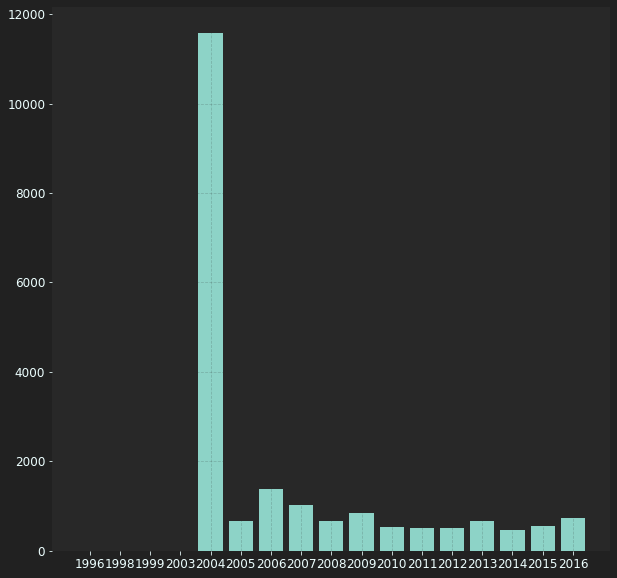

In [4]:
qnt_receitas = list(map(lambda x:len(x), df_group_year.groups.values()))
anos = df_group_year.groups.keys()

bar(x=anos, height=qnt_receitas)

In [5]:
df_features = df_group_year.get_group("2005")

Mudando os planos para 2005 em diante devido a quantidade de receitas disponíveis...

In [6]:
df_features.describe()

,id,calories,fat,protein,rating,sodium
count,661.000000,581.000000,580.000000,580.000000,661.000000,581.000000
mean,10257.193646,482.571429,26.986207,21.943103,3.959909,654.060241
std,5766.688136,469.658772,35.290404,35.212288,0.989241,1135.977899
min,42.000000,2.000000,0.000000,0.000000,0.000000,1.000000
25%,5473.000000,206.000000,9.000000,4.000000,3.750000,106.000000
50%,10503.000000,357.000000,19.000000,9.000000,4.375000,359.000000
75%,15435.000000,607.000000,35.000000,30.000000,4.375000,913.000000
max,20128.000000,5656.000000,599.000000,372.000000,5.000000,16813.000000


In [7]:
df_features = df_features.dropna()

In [8]:
features = df_features[["fat", "calories", "sodium", "protein", "rating"]]

<AxesSubplot:>

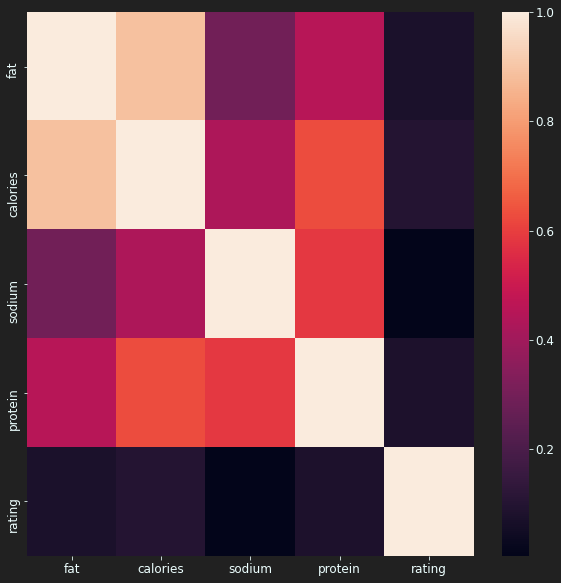

In [9]:
sns.heatmap(features.corr())

In [10]:
features.pop("rating");

removendo rating (baixíssima correlação com o resto)...

<AxesSubplot:>

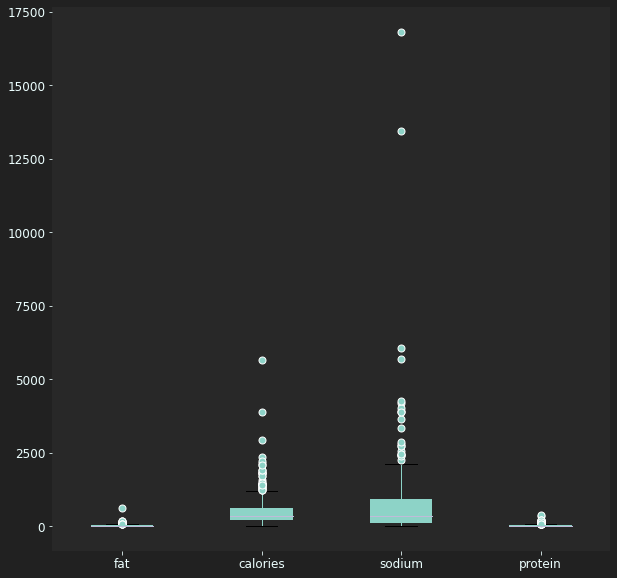

In [11]:
features.plot.box()

muito outliers... utilizando método interquartile

In [12]:
def interquartile(df):
    
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)
    IQR = df.apply(stats.iqr)

    return df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]

features = interquartile(features)

<AxesSubplot:>

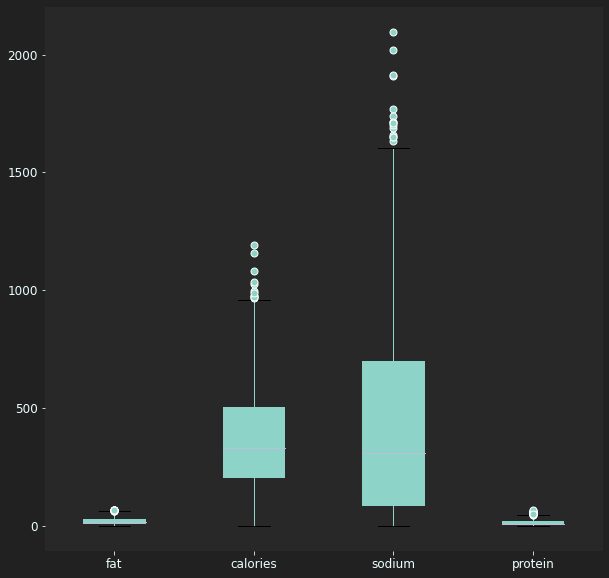

In [13]:
features.plot.box()

In [14]:
df_features[["fat", "calories", "sodium", "protein"]] = features

## cuidando das categorias

In [15]:
df_categories = pd.read_sql_query("""
            SELECT recept.id, recept.date, categorie.name
            FROM categorie
            INNER JOIN categorierecept ON categorierecept.categorie_id = categorie.id
            INNER JOIN recept ON recept.id = categorierecept.recept_id
            """,
            engine,  parse_dates=['date']
)

In [16]:
df_cat_group = df_categories.groupby("id")

In [17]:
def prepare_word2vec(df_features, df_cat_group, size=10):
    categories_dataset = []

    for i in df_features.id.tolist():
        try:
            categories_dataset.append(df_cat_group.get_group(i).name.tolist())
        except KeyError:
            index = df_features.id[[i]].index
            df_features.drop(index=i-1)
            
    word2vec = gensim.models.Word2Vec(sentences=categories_dataset,
                                      window=3, min_count=1, sg=1, size=size)
    return word2vec

In [18]:
word2vec = prepare_word2vec(df_features, df_cat_group)

nesta etapa tento criar a correlação entre os vetores que representam as palavras no word2vec (sg=1 ~> skip-gram) com os dados sobre proteínas, gorduras e colesterol, para mais à frente fazer o treinamento com esse conjunto de dados para prever o sódio em determinado ano.

In [19]:
def get_max_size(data_nlp):

    mx = 0
    for i in data_nlp:
        n = len(i)
        if n > mx:
            mx = n
    return mx

In [20]:
def prepare_nlp(df_features, df_cat_group, word2vec, size=10):

    data_nlp = []
    target_nlp = []

    for i in tqdm(df_features.dropna().id.tolist()):
        target_nlp.append(df_features.query(f"id == {i}")[["calories", "fat", "protein"]])

        group = df_cat_group.get_group(i)
        words_vec = []
        for name in group.name:
            try:
                words_vec.append(word2vec.wv[name])
            except:
                # pensando nos dados ficando defasados, desconsiderando novas keywords
                pass
        data_nlp.append(words_vec)
    
    data_len = len(data_nlp)
    mx = get_max_size(data_nlp)
    data_nlp_array = zeros((data_len, mx*size))
    
    for i in range(data_len):
        for words in data_nlp[i]:
            for j, word in enumerate(words):
                a = j*size
                b = (j+1)*size
                data_nlp_array[i, a:b] = word
            
    
    return data_nlp_array.astype(np.float64), array(target_nlp).reshape(-1, 3).astype(np.float64)

In [21]:
data_nlp, target_nlp = prepare_nlp(df_features, df_cat_group, word2vec)

In [22]:
word2vec.wv["bake"]

array([-0.33065158, -0.21893723, -0.5084465 , -0.02642694, -0.6647644 ,
        0.05711524, -0.28452042,  0.2878336 , -0.03004181,  0.83844084],
      dtype=float32)

In [23]:
data_nlp.shape, target_nlp.shape

((516, 260), (516, 3))

In [24]:
from sklearn.tree import DecisionTreeRegressor

In [47]:
clf = DecisionTreeRegressor(max_depth=10000)
clf.fit(data_nlp, target_nlp)

DecisionTreeRegressor(max_depth=10000)

In [48]:
clf.score(data_nlp, target_nlp)

0.19388231814676857

In [49]:
predicts = clf.predict(data_nlp)

<AxesSubplot:>

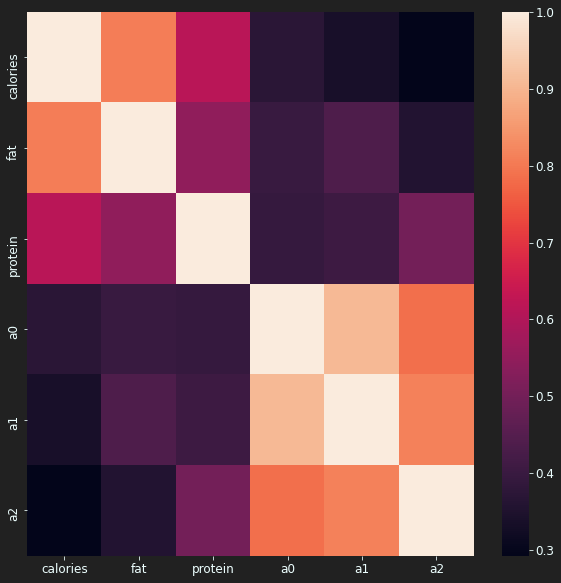

In [50]:
rows = target_nlp.shape[0]
cols = 6

_matrix = np.zeros((rows, cols))
_matrix[:, :3] = target_nlp
_matrix[:, 3:] = predicts

_df = pd.DataFrame(_matrix, columns=["calories", "fat", "protein", "a0", "a1", "a2"])

sns.heatmap(_df.corr())

In [ ]:
df_copy

## Treinamento e comparações ao longo do tempo

In [ ]:
df_train = df_features.dropna()

X_train = df_train[["calories", "fat", "protein"]]
Y_train = df_train.sodium

In [ ]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, Y_train)

In [ ]:
svr.score(X_train, Y_train)

In [ ]:
def pipeline(df_group_year, year):
    features = df_group_year.get_group(f"{year}")[["calories", "fat", "protein", "sodium"]].dropna()
    features = interquartile(features)
    X = features[["calories", "fat", "protein"]]
    Y = features.sodium
    return X, Y

In [ ]:
x_2010, y_2010 = pipeline(df_group_year, 2016)

In [ ]:
svr.score(x_2010, y_2010)

In [ ]:
scores = []
years = []
for year in list(df_group_year.groups.keys())[1:]:
    X, Y = pipeline(df_group_year, year)
    score = svr.score(X, Y)
    print(year, score)
    years.append(year)
    scores.append(score)

In [ ]:
plot(scores[3:])
xticks(range(len(years[3:])), years[3:]);